# SVM multietiqueta con búsqueda Repeated K‑Fold
Se entrena un **Support Vector Machine** (kernel lineal) en esquema *One‑vs‑Rest* para clasificación multietiqueta. La búsqueda de hiperparámetros se realiza con **Repeated K‑Fold CV** (5×3).

Se incluyen:
* Gráfica de optimización de λ (λ = 1/C).
* Curva de aprendizaje (F1‑micro).

## Bloque 1 – Importaciones
Añadimos `LinearSVC` y métricas relevantes.

In [1]:
# ----- Bloque 1 -----
import os, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, hamming_loss, make_scorer


## Bloque 2 – Ruta


In [2]:
# ----- Bloque 2 -----
if os.path.basename(os.getcwd()) != 'Seismic-Multilabel-Event-Classifier':
    os.chdir('..')
    print('CWD ->', os.getcwd())

CWD -> /Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier


## Bloque 3 – Carga de datos


In [3]:
# ----- Bloque 3 -----
df = pd.read_json('data/processed/dataset_final.json')
print('Shape:', df.shape)
df.head()

Shape: (1674, 91)


,max_V,rms_V,max_H1,rms_H1,max_H2,rms_H2,duration,zcr_V,dom_freq_V,centroid_V,...,FFT_PCA_62,1 Stiker Slip (SS),2 Normal-Oblique (SO),3 Reverse-Oblique (RO),4-6,6-8,0-200,200-400,400-600,600-
0,0.000342,0.000052,0.000587,0.000111,0.000617,0.000107,321.68,2.014362,0.000000,5.447156,...,0.015319,True,False,False,True,False,False,False,False,True
1,0.003967,0.000347,0.006399,0.000501,0.004988,0.000475,200.00,9.034548,0.781250,17.551070,...,0.015314,True,False,False,True,False,False,False,False,True
2,0.000135,0.000023,0.000204,0.000028,0.000157,0.000026,323.79,1.429895,0.195312,2.573894,...,0.015312,True,False,False,True,False,False,False,False,True
3,0.003166,0.000453,0.005030,0.000657,0.004669,0.000725,41.00,21.189954,14.062500,14.019404,...,0.001835,True,False,False,True,False,False,False,False,True
4,0.000011,0.000002,0.000021,0.000003,0.000018,0.000003,180.80,3.943366,0.195312,10.936094,...,0.015316,True,False,False,True,False,False,False,False,True


## Bloque 4 – Separación X/y


In [4]:
# ----- Bloque 4 -----
label_cols = ['1 Stiker Slip (SS)','2 Normal-Oblique (SO)','3 Reverse-Oblique (RO)',
              '4-6','6-8','0-200','200-400','400-600','600-']
drop_cols = ['Archivo','Falla_lbl','Mag_lbl','Vs_lbl','Combo'] + label_cols
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].values
y = df[label_cols].values
print('X:', X.shape, 'y:', y.shape)

X: (1674, 82) y: (1674, 9)


## Bloque 5 – Hold‑out Test


In [5]:
# ----- Bloque 5 -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (1339, 82) Test: (335, 82)


## Bloque 6 – Pipeline base


In [6]:
# ----- Bloque 6 -----
base_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', OneVsRestClassifier(LinearSVC(max_iter=5000)))
])

## Bloque 7 – Grid y Repeated K‑Fold


In [7]:
# ----- Bloque 7 -----
C_vals = np.logspace(-3, 2, 10)
param_grid = {'clf__estimator__C': C_vals}

rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
scorer = make_scorer(f1_score, average='micro')

grid = GridSearchCV(base_pipe, param_grid, scoring=scorer,
                    cv=rkf, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

best_C = grid.best_params_['clf__estimator__C']
print('Mejor C:', best_C)
print('Mejor F1 CV:', grid.best_score_)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
[CV] END ............................clf__estimator__C=0.001; total time=   0.1s
[CV] END ............................clf__estimator__C=0.001; total time=   0.1s
[CV] END ............................clf__estimator__C=0.001; total time=   0.1s
[CV] END ............................clf__estimator__C=0.001; total time=   0.1s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.1s
[CV] END ............................clf__estimator__C=0.001; total time=   0.1s
[CV] END ............................clf__estimator__C=0.001; total time=   0.1s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.1s
[CV] END ............................clf__esti

/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................clf__estimator__C=100.0; total time=   0.8s
[CV] END ............................clf__estimator__C=100.0; total time=   0.7s
[CV] END ...............clf__estimator__C=27.825594022071257; total time=   2.2s
[CV] END ...............clf__estimator__C=27.825594022071257; total time=   2.0s
[CV] END ............................clf__estimator__C=100.0; total time=   1.6s
[CV] END ............................clf__estimator__C=100.0; total time=   1.3s
[CV] END ............................clf__estimator__C=100.0; total time=   0.7s
[CV] END ............................clf__estimator__C=100.0; total time=   1.3s
[CV] END ............................clf__estimator__C=100.0; total time=   0.9s
[CV] END ............................clf__estimator__C=100.0; total time=   0.9s
[CV] END ............................clf__estimator__C=100.0; total time=   1.1s
[CV] END ............................clf__estimator__C=100.0; total time=   1.9s


/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................clf__estimator__C=100.0; total time=   2.3s


/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................clf__estimator__C=100.0; total time=   2.0s
Mejor C: 100.0
Mejor F1 CV: 0.5167707232330455


## Bloque 8 – Optimización λ


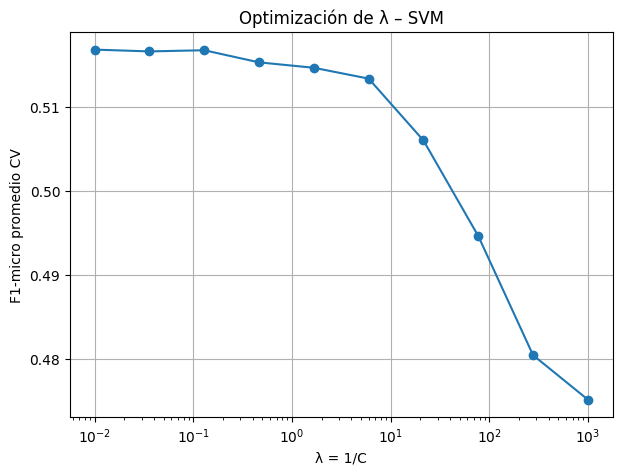

In [8]:
# ----- Bloque 8 -----
res = pd.DataFrame(grid.cv_results_)
res['lambda'] = 1 / res['param_clf__estimator__C'].astype(float)
means = res.groupby('lambda')['mean_test_score'].mean().sort_index()

plt.figure(figsize=(7,5))
plt.plot(means.index, means.values, marker='o')
plt.xscale('log')
plt.xlabel('λ = 1/C')
plt.ylabel('F1-micro promedio CV')
plt.title('Optimización de λ – SVM')
plt.grid(True)
plt.show()

## Bloque 9 – Curva de aprendizaje


/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklea

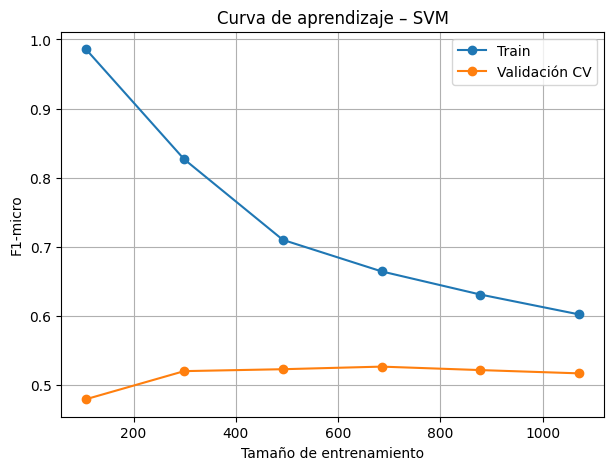

In [9]:
# ----- Bloque 9 -----
best_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', OneVsRestClassifier(LinearSVC(C=best_C, max_iter=5000)))
])

train_sizes, tr_scores, val_scores = learning_curve(
    best_pipe, X_train, y_train,
    cv=rkf, scoring=scorer,
    train_sizes=np.linspace(0.1,1.0,6),
    n_jobs=-1
)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, tr_scores.mean(axis=1), 'o-', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validación CV')
plt.xlabel('Tamaño de entrenamiento')
plt.ylabel('F1‑micro')
plt.title('Curva de aprendizaje – SVM')
plt.legend(); plt.grid(True); plt.show()

## Bloque 10 – Evaluación Test


In [10]:
# ----- Bloque 10 -----
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
print('Test F1‑micro:', f1_score(y_test, y_pred, average='micro'))
print('Test Hamming loss:', hamming_loss(y_test, y_pred))

Test F1‑micro: 0.533974744437763
Test Hamming loss: 0.2570480928689884


## Bloque 11 – Guardar modelo


In [11]:
# ----- Bloque 11 -----
os.makedirs('models', exist_ok=True)
joblib.dump(best_pipe, 'models/svm_repkfold.pkl')
print('Modelo guardado en models/svm_repkfold.pkl')

Modelo guardado en models/svm_repkfold.pkl
